# Estimation of whole-brain effective connectivity via MOU process (MOU-EC) 

**Created by: _Matthieu Gilson & Gorka Zamora-López_**

The Human Brain Project SGA0 - SGA2 (SP4); SGA3 (WP1)  /  Pompeu Fabra University, Barcelona.

<img src="Logo_HBP_small.png" style="float:left; width:254px; heigth:50px " alt="HBP logo" />
<img src="Logo_UPF_small.png" style="float:right; width:149px; height:50px"  alt="UPF logo" />


<br/>
<br/>

-----------------
The purpose of this notebook is to showcase, test and validate the integration of effective connectivity tools in EBRAINS and for use in broader workflows. This notebook should:

- Retrieve and load structural connectivity and fMRI-BOLD data available in EBRAINS.
- Estimate effective connectivity using the _pyMOU_ Python package (_pyMOU_ should be available in the Python environment of the EBRAINS Lab, instead of having to perform a local install via '_pip_').
- Save / export the resulting EC matrices and metadata for later use in further workflows within EBRAINS

-----------------

Here we will estimate whole-brain effective connectivity from multivariate brain activity as measured via functional MRI. The time-series are represented as the average activity of voxels grouped into Regions Of Interest (ROIs) following a parcellation. Effective connectivity is an estimate of the causal interactions between brain regions and it requires assuming a dynamical model to emulate how activity propagates along the brain. MOU-EC considers the *Multivariate Ornstein-Uhlenbeck process* as this core dynamical model. See the following references for details:


#### References and documentation

1. M. Gilson, R. Moreno-Bote, A. Ponce-Alvarez, et al. (2016) "Estimation of Directed Effective Connectivity from fMRI Functional Connectivity Hints at Asymmetries of Cortical Connectome." PLoS Comput. Biol. 12(3): e1004762.
DOI: https://doi.org/10.1371/journal.pcbi.1004762
2. M Gilson, G. Deco, K. Friston et al. (2018) "Effective connectivity inferred from fMRI transition dynamics during movie viewing points to a balanced reconfiguration of cortical interactions." NeuroImage 180, 534-546.
DOI: https://doi.org/10.1016/j.neuroimage.2017.09.061
3. M. Gilson, G. Zamora-López, V. Pallarés, et al. (2020) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease." Network Neurosci. 4(2), 338-373.
DOI: https://doi.org/10.1162/netn_a_00117


#### Software
We employ the python package 'pyMOU' for estimating effective connectivity.
GitHub: https://github.com/mb-BCA/pyMOU


#### Data
We employ structural connectivity and resting-state fMRI from the ARCHI dataset, consisting of recording for a cohort of 77 healthy participants. Data recorded and preprocessed in NeuroSpin institute.

1. Y. Assaf, D.C. Alexander, D.K. Jones, et al. (2013) "The CONNECT project: combining macro- and micro-structure". NeuroImage 80, 273–282. 
DOI: https://doi.org/10.1016/j.neuroimage.2013.05.055.
2. D. Duclap, A. Lebois, B Schmitt (2012) "Connectomist-2.0: a novel diffusion analysis toolbox for BrainVISA." In: 29th ESMRMB. Lisbone, Portugal.



---------
### TO-DO list towards full EBRAINS integration 
Missing technical points, for full integration of the workflows in this notebook.

- Interface to select, retrieve and load a selected dataset from EBRAINS.
- Incorporate 'pyMOU' to the Python packages available in EBRAINS by default.
- Interface to visualization services. Visualise results in a "standard brain map"
- Interface to export results to other tools and utilities in EBRAINS. It may be sufficient to store the results (the EC matrices) in the Drive and read them from another notebook. But ... any fancier method?


----------
### Import the dependencies

In [1]:
# Import standard library modules
import os
# Import 3rd party packages
import numpy as np
import scipy.signal as spsg
import scipy.stats as stt
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
## TO-DO: pyMOU shall be available in EBRAINS, by default

## Check whether pyMOU is installed, otherwise install using pip
try:
    import pymou
except:
    ! pip install git+https://github.com/mb-BCA/pyMOU.git@master

## Import pyMOU
from pymou.mou_model import MOU

### Load and prepare the functional data (fMRI)

So far, we read datafiles stored in the local Drive of this collab: _'.../Effective Connectivity estimation/Datasets/ARCHI/'_ 

**!! TO-DO**: Use an interface to load the data directly from the KG. **!!**

The data files are:

- 'BOLD_allsubs_xxxx.npy': BOLD time series (functional data). 'xxxx' stands for the parcellation.
- 'SC_Average_30perc_xxxx.npy': anatomical connectome, averaged over subjects (structural data). 'xxxx' stands for the parcellation.
- 'ROI_Labels_xxxx.npy': names of ROIs

We will filter the fMRI data in the broad frequency band \[0.01, 0.1\] Hz, mainly to detrend the data from ultra-slow BOLD oscillations (with periods larger than 100 seconds).



In [3]:
%pwd

'/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Jupyter_Notebooks'

In [4]:
## Load the fMRI data from the Drive
## TO-DO: Use an interface to load the data directly from the KG.

datapath = '/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Datasets/'
parcellation = 'Desikan'   # Desikan,  Constellation
datafname = 'BOLD_allsubs_%s.npy' %parcellation

ts_emp = np.load( datapath + 'ARCHI/' + datafname )
n_sub, N, T = np.shape(ts_emp)

# Print some feedback
print( 'Number of subjects:', n_sub )
print( 'Number of ROIs:', N )
print( 'Time samples (volumes):', T )


Number of subjects: 77
Number of ROIs: 68
Time samples (volumes): 242


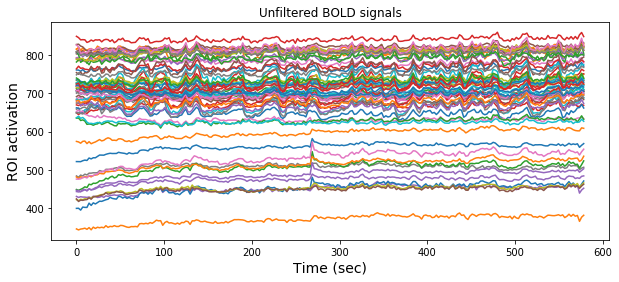

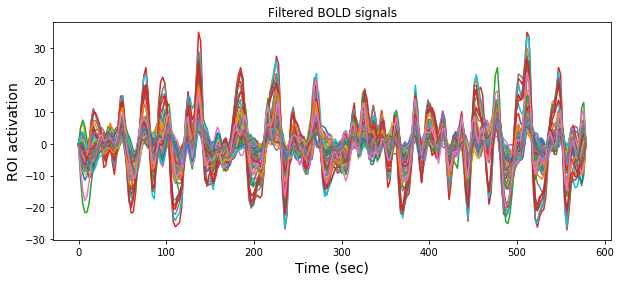

In [5]:
# Band-pass filter the BOLD signals, between 0.01 and 0.1 Hz

# Time resolution of fMRI/BOLD data (in seconds)
TR = 2.4
tpoints = TR * np.arange(T, dtype=np.float)

# Create a filter, using scipy.signal
n_order = 3
Nyquist_freq = 0.5 / TR
low_f = 0.01 / Nyquist_freq
high_f = 0.1 / Nyquist_freq
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

# Finally, filter the signals
filtered_ts_emp = spsg.filtfilt(b, a, ts_emp, axis=2)

# Plot some BOLD for comparison
plt.figure(figsize=(10,4))
plt.plot(tpoints, ts_emp[0].T)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('ROI activation', fontsize=14)
plt.title('Unfiltered BOLD signals')

plt.figure(figsize=(10,4))
plt.plot(tpoints, filtered_ts_emp[0].T)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('ROI activation', fontsize=14)
plt.title('Filtered BOLD signals')

plt.show()

### Load the structural connectivity data

In MOU-EC structural connectivity can be employed to constrain the optimization process. Although this is not always necessary, the low temporal resolution of fMRI limits the power of the optimization. Thus,  masking the connectivity helps to reduce the number of free parameters (number of connections) to be fitted.

In [6]:
## Load the SC data from the Drive. Since we only need the SC to mask the 
## EC estimation, we will only load an average connectivity template, with
## 30% connection density.

## TO-DO: Use an interface to load the data directly from the KG.

datapath = '/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Datasets/'
parcellation = 'Desikan'   # Desikan,  Constellation
datafname = 'SC_Average_30perc_%s.npy' %parcellation

SC_anat = np.load( datapath + 'ARCHI/' + datafname )
N =len(SC_anat)

# Print some feedback
print( 'Number of ROIs:', N )

Number of ROIs: 68


EC density: 0.3086040386303775


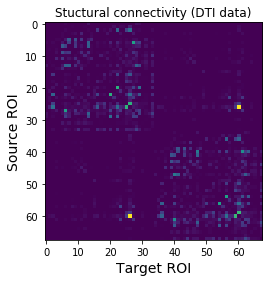

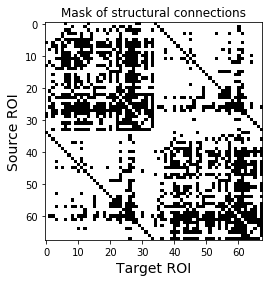

In [7]:
# Define the connectivity mask from the average SC
mask_EC = SC_anat.astype(bool)

# Remove self connections
for i in range(N):
    mask_EC[i, i] = False

# Add the homotopic inter-hemispheric connections
for i in range(int(N/2)):
    mask_EC[i, i+int(N/2)] = True
    mask_EC[i+int(N/2), i] = True

print('EC density:', mask_EC.sum()/float(N*(N-1)))

# Visualize the structural connectivty and the mask
plt.figure()
plt.imshow(SC_anat)
plt.xlabel('Target ROI', fontsize=14)
plt.ylabel('Source ROI', fontsize=14)
plt.title('Stuctural connectivity (DTI data)')

plt.figure()
plt.imshow(mask_EC, cmap='gray_r')
plt.xlabel('Target ROI', fontsize=14)
plt.ylabel('Source ROI', fontsize=14)
plt.title('Mask of structural connections')

plt.show()

## MOU-EC estimation

Finally, run the EC estimation for all the subjects by calling the MOU model from the pyMOU library.

In [10]:
# Run the model optimization 
# WARNING: Running this cell will take a few minutes.
# Start initializing the target arrays
EC_mod = np.zeros([n_sub,N,N], np.float)     # The effective connectivity matrices
J_mod = np.zeros([n_sub,N,N], np.float)      # The Jacobian matrices of the MOU model
Sigma_mod = np.zeros([n_sub,N,N], np.float)  # local variance (input covariance matrix, chosen to be diagonal)
tau_list = np.zeros(n_sub, np.float)         # Estimated decay rate (time-constant)
dist_mod = np.zeros([n_sub], np.float)       # Model error
R2_mod = np.zeros([n_sub], np.float)         # Explained variance about the fitted data (FC covariance matrices)

# Creat the diagonal mask for the input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N, dtype=bool)

# Create an instance of the MOU model
mou_model = MOU()

for i_sub in range(n_sub):
    # 1) Run the estimation of model parameters, for each subject
    mou_model.fit(filtered_ts_emp[i_sub].T, mask_C=mask_EC, 
                                    mask_Sigma=mask_Sigma) 

    # 2) Organize the optimization results into arrays
    # The estimated EC matrix
    J_mod[i_sub] = mou_model.J
    # The estimated EC matrix
    EC_mod[i_sub] = mou_model.get_C() 
    # The estimated time-constant
    tau_list[i_sub] = np.mean( mou_model.get_tau_x() )
    # Noise (auto-)covariance matrix
    Sigma_mod[i_sub] = mou_model.Sigma
    # Matrix distance between the empirical objective covariances and 
    # their model counterparts 
    # (normalized for each objective matrix)
    dist_mod[i_sub] = mou_model.d_fit['distance'] 
    # The squared Pearson correlation is taken as an approximation of 
    # the variance explained R2 here
    R2_mod[i_sub] = mou_model.d_fit['correlation']**2 

    print('sub:',i_sub,'; model error /  R2:', 
              dist_mod[i_sub], '/', R2_mod[i_sub])


print( '\nFinished.')


sub: 0 ; model error /  R2: 0.3062229576822539 / 0.904741021066705
sub: 1 ; model error /  R2: 0.2789917714260952 / 0.7319870932606078
sub: 2 ; model error /  R2: 0.5908450828988215 / 0.4649867833583574
sub: 3 ; model error /  R2: 0.27794442712511924 / 0.7893346802884119
sub: 4 ; model error /  R2: 0.5673704321638992 / 0.26103997418505154
sub: 5 ; model error /  R2: 0.3084048717786693 / 0.8067536633168451
sub: 6 ; model error /  R2: 0.3002147663659208 / 0.8765384343017402
sub: 7 ; model error /  R2: 0.5382301120908295 / 0.31822896803712064
sub: 8 ; model error /  R2: 0.6616884355419327 / 0.36568959748962093
sub: 9 ; model error /  R2: 0.36645822294167574 / 0.751297156831863
sub: 10 ; model error /  R2: 0.3703865327659499 / 0.7589290038654225
sub: 11 ; model error /  R2: 0.24159328536917452 / 0.8934590953683541
sub: 12 ; model error /  R2: 0.35813348016382296 / 0.7994239274979861
sub: 13 ; model error /  R2: 0.3311009095789148 / 0.8385099987163561
sub: 14 ; model error /  R2: 0.37791395

In [11]:
# Save the results and the metadata into a file for later use

outfname = 'ECdata_30perc_%s.npz' %parcellation

np.savez( datapath + 'ARCHI/' + outfname,
          mask_EC = mask_EC,       # mask of optimized connections
          mask_Sigma = mask_Sigma, # mask of optimized Sigma elements
          J_mod = J_mod,           # the Jacobian matrices 
          EC_mod = EC_mod,         # estimated EC matrices
          Sigma_mod = Sigma_mod,   # estimated Sigma matrices
          tau_list = tau_list,     # estimated time-constants
          dist_mod = dist_mod,     # model errors
          R2_mod = R2_mod )      # variance explained 

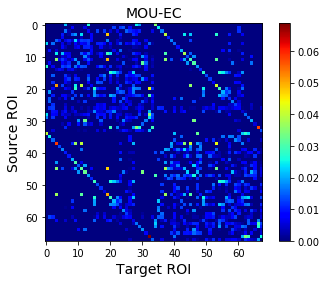

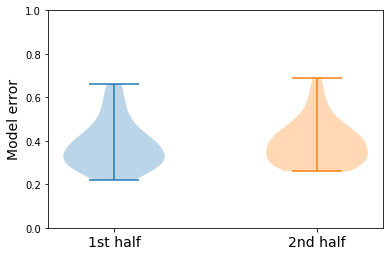

In [12]:
# Display some results

# Show the MOU-EC matrix for one subjet
i_sub = 0

plt.figure()
plt.imshow(EC_mod[i_sub], cmap='jet')
plt.xlabel('Target ROI', fontsize=14)
plt.ylabel('Source ROI', fontsize=14)
plt.colorbar()
plt.title('MOU-EC', fontsize=14)


# Show the model error
# Split subjects in halves to check consistency of model fitting
plt.figure()
plt.violinplot(dist_mod[:int(n_sub/2)],positions=[0])
plt.violinplot(dist_mod[int(n_sub/2):],positions=[1])
plt.ylim(0,1)
plt.xticks([0,1], ['1st half', '2nd half'], fontsize=14)
plt.ylabel('Model error', fontsize=14)

plt.show()